In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from datetime import datetime

In [80]:
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

In [81]:
# Get data from CSV
data = pd.read_csv('MUP_dataset.csv',header=12, parse_dates = [['YEAR', 'MO', 'DY', 'HR']], index_col=0, date_parser=parse)
data.index.name = 'date'
data.columns = ['Pressure','Wind Speed 50','Wind Speed 10','Temperature']
print(data.head(5))

                     Pressure  Wind Speed 50  Wind Speed 10  Temperature
date                                                                    
2016-01-01 05:00:00     98.49           6.54           3.38        18.79
2016-01-01 06:00:00     98.57           5.91           3.48        19.26
2016-01-01 07:00:00     98.66           5.74           4.70        21.07
2016-01-01 08:00:00     98.72           7.67           6.18        22.94
2016-01-01 09:00:00     98.72           8.40           6.94        24.27


2022-04-20 06:35:09.052210: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-04-20 06:35:09.070257: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


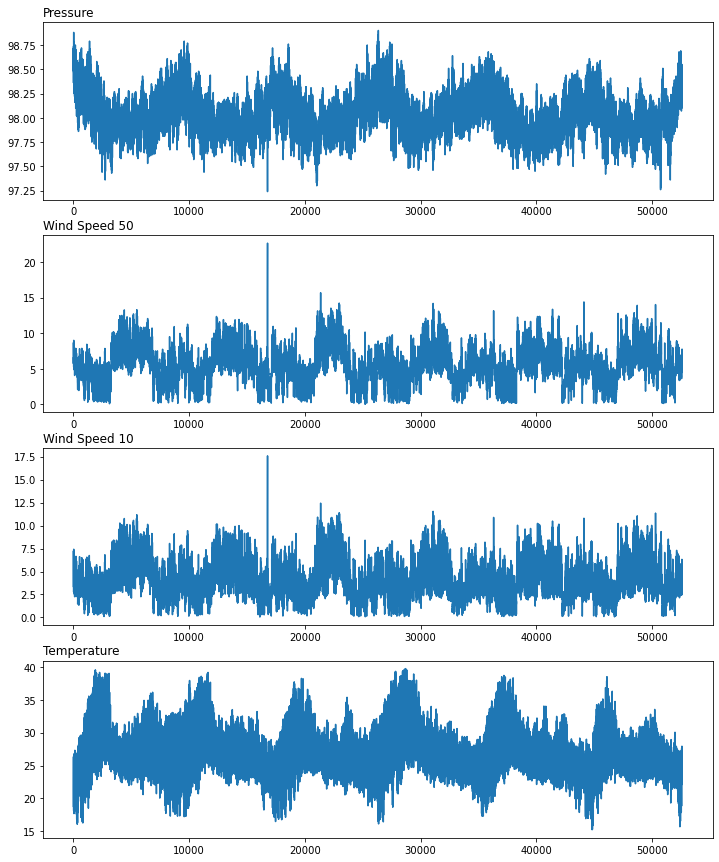

In [82]:
# Plot for each feature
values = data.values
groups = [0, 1, 2, 3]
i = 1
plt.figure(figsize=(12, 15))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(data.columns[group], y=1, loc='left')
	i += 1
# every data is hour step, and until 8760 units = 24 hours each day in one year.
plt.show()

In [83]:
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
target_var = 'Wind Speed 50'
X_data = X_scaler.fit_transform(data[['Pressure','Wind Speed 50','Wind Speed 10','Temperature']])
Y_data = Y_scaler.fit_transform(data[[target_var]])

In [84]:
def custom_ts_multi_data_prep(dataset,target,start,end,window,horizon):
    X = []
    y = []
    start = start+window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start,end):
        indicex = range(i-window,i)
        X.append(dataset[indicex])
        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [85]:
len(X_data),len(Y_data)

(52608, 52608)

In [86]:
hist_window = 100
horizon = 10
TRAIN_SPLIT = int(len(X_data)*0.75)
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

In [87]:
print ('Multiple window of past history\n')
print(x_train[0])
print ('\n Target horizon\n')
print (y_train[0])


Multiple window of past history

[[0.75301205 0.2882405  0.19006849 0.1451876 ]
 [0.80120482 0.26038904 0.19577626 0.16435563]
 [0.85542169 0.25287356 0.26541096 0.23817292]
 [0.89156627 0.33819629 0.34988584 0.31443719]
 [0.89156627 0.37046861 0.39326484 0.36867863]
 [0.86746988 0.38240495 0.4086758  0.40660685]
 [0.81927711 0.38284704 0.41038813 0.43393148]
 [0.75903614 0.37931034 0.40468037 0.45106036]
 [0.71084337 0.37267905 0.39383562 0.45309951]
 [0.6746988  0.36604775 0.38127854 0.44698206]
 [0.6746988  0.3576481  0.35844749 0.4274062 ]
 [0.71084337 0.33377542 0.29509132 0.38866232]
 [0.76506024 0.32758621 0.21974886 0.31973899]
 [0.8253012  0.32714412 0.20547945 0.27650897]
 [0.87349398 0.29619805 0.18949772 0.25163132]
 [0.90361446 0.27984085 0.17865297 0.22879282]
 [0.90361446 0.27718833 0.17751142 0.21044046]
 [0.87951807 0.27586207 0.17694064 0.19290375]
 [0.84939759 0.27409372 0.17694064 0.17822186]
 [0.81325301 0.27365164 0.17636986 0.16598695]
 [0.77108434 0.2714412  0.1

In [88]:
len(x_train),len(x_vali)

(39356, 13042)

In [89]:
batch_size = 32
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()
val_data


<RepeatDataset element_spec=(TensorSpec(shape=(None, 100, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 10, 1), dtype=tf.float64, name=None))>

In [90]:
def lstm():
    lstm_model = tf.keras.models.Sequential(
        [   
            tf.keras.layers.LSTM(200,input_shape =x_train.shape[-2:],activation="relu"),
            tf.keras.layers.Dense(48, activation="sigmoid"),
            tf.keras.layers.Dense(48, activation="tanh"),
            tf.keras.layers.Dense(24, activation="sigmoid"),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Dense(units=horizon),
        ],
    )
    lstm_model.compile(optimizer="adam", loss="mse")
    lstm_model.summary()
    return lstm_model



In [91]:

def mlp():
    mlp_model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(200,input_shape =x_train.shape[-2:]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation="tanh"),
        tf.keras.layers.Dense(72, activation="tanh"),
        tf.keras.layers.Dense(36, activation="tanh"),
        tf.keras.layers.Dense(36, activation="tanh"),
        tf.keras.layers.Dense(36, activation="tanh"),
        tf.keras.layers.Dense(24, activation="tanh"),
        tf.keras.layers.Dense(units=horizon),
    ])
    mlp_model.compile(optimizer="adam", loss="mse")
    mlp_model.summary()
    return mlp_model

In [92]:
model_path = "LSTM_Multivariate.h5"
early_stopings = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=10, verbose=1, mode="min"
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_path, monitor="val_loss", save_best_only=True, mode="min", verbose=0
)
callbacks = [early_stopings, checkpoint]

model = lstm()

history = model.fit(
    train_data,
    epochs=100,
    steps_per_epoch=10,
    validation_data=val_data,
    validation_steps=50,
    verbose=1,
    callbacks=callbacks,
)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 200)               164000    
                                                                 
 dense_20 (Dense)            (None, 48)                9648      
                                                                 
 dense_21 (Dense)            (None, 48)                2352      
                                                                 
 dense_22 (Dense)            (None, 24)                1176      
                                                                 
 dropout_5 (Dropout)         (None, 24)                0         
                                                                 
 dense_23 (Dense)            (None, 10)                250       
                                                                 
Total params: 177,426
Trainable params: 177,426
Non-tr

2022-04-20 06:35:10.709211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 6/10 [=================>............] - ETA: 29s - loss: 0.6311

KeyboardInterrupt: 

In [ ]:
history.history

{'loss': [0.2902185320854187,
  0.09537593275308609,
  0.08003205060958862,
  0.07389312237501144,
  0.06595869362354279,
  0.06230508163571358,
  0.0576416440308094,
  0.05499792471528053,
  0.05149528384208679,
  0.04739842563867569,
  0.04645552113652229,
  0.04381149634718895,
  0.040860023349523544,
  0.03899961709976196,
  0.03907916694879532,
  0.0358743742108345,
  0.03453534469008446,
  0.034972116351127625,
  0.03203800693154335,
  0.03143131360411644,
  0.03172596916556358,
  0.02869337424635887,
  0.028684062883257866,
  0.029215538874268532,
  0.02653590403497219,
  0.026924340054392815,
  0.025343850255012512,
  0.0262068472802639,
  0.025215499103069305,
  0.023553648963570595,
  0.02423066832125187,
  0.02403358928859234,
  0.022689713165163994,
  0.022126853466033936],
 'val_loss': [0.040075886994600296,
  0.014458522200584412,
  0.011907484382390976,
  0.010673508048057556,
  0.011010375805199146,
  0.011054915376007557,
  0.011003509163856506,
  0.010747675783932209,

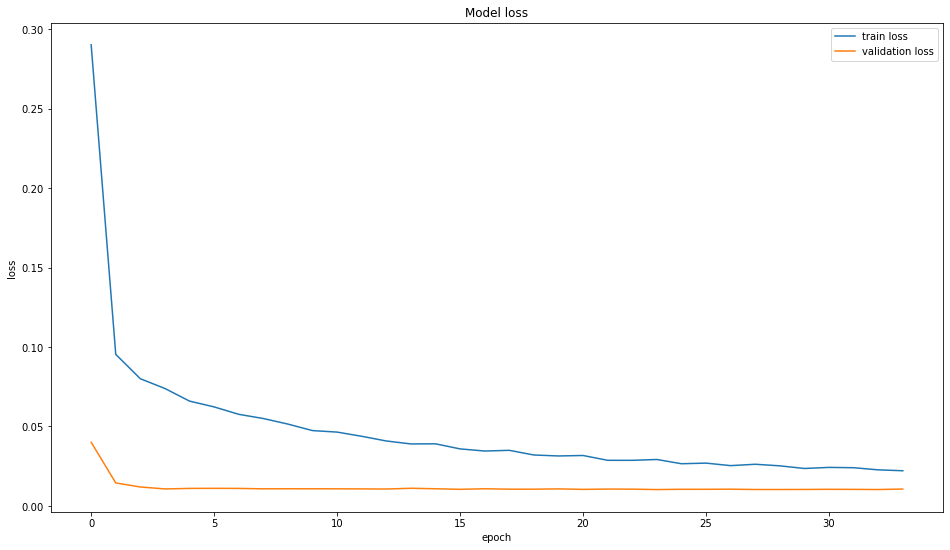

In [ ]:
# plot history
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show() 

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true) * 100)
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
inputData = data[['Pressure','Wind Speed 50','Wind Speed 10','Temperature']].tail(hist_window+horizon)

data_val = X_scaler.fit_transform(inputData.head(hist_window))
val_rescaled = data_val.reshape(1,data_val.shape[0],data_val.shape[1])
pred = model.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse

2022-04-20 06:24:07.583535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 06:24:07.653494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[4.9797907, 5.688253 , 4.9435086, 5.4625325, 5.0812473, 5.1034417,
        5.039144 , 5.170867 , 4.9996314, 5.018983 ]], dtype=float32)

In [ ]:
true_wind_data = data[[target_var]].tail(horizon)
validate = []
validate.append(true_wind_data.values)
validate = np.array(validate)
print(validate)


[[[6.99]
  [7.34]
  [7.64]
  [7.77]
  [7.66]
  [7.63]
  [7.36]
  [6.86]
  [6.48]
  [6.32]]]


In [ ]:
timeseries_evaluation_metrics_func(validate[0],pred_Inverse[0])

Evaluation metric results:-
MSE is : 4.452182338445023
MAE is : 2.0562600898742676
RMSE is : 2.1100195113896514
MAPE is : 28.19091695814536
R2 is : -17.455024304939073



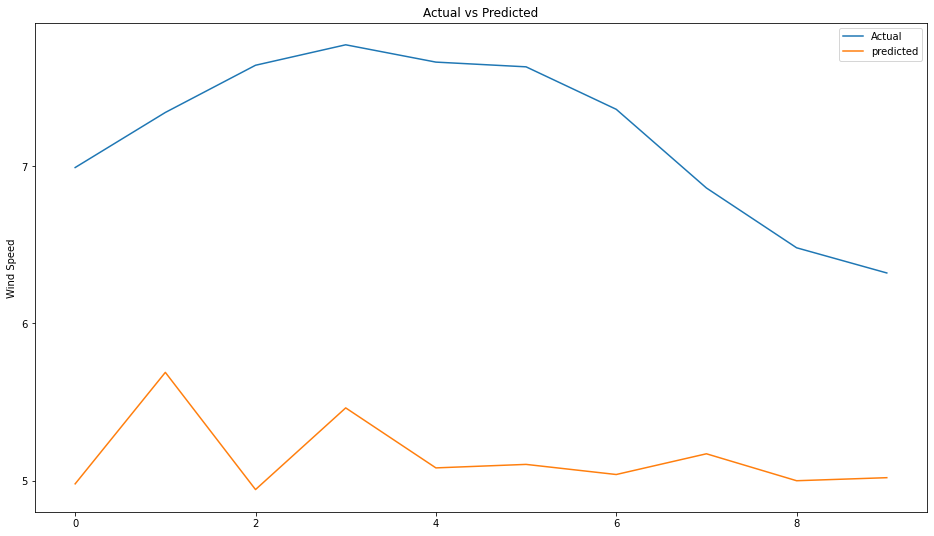

In [ ]:
from matplotlib.ticker import MaxNLocator
# import random

# for i in range(len(validate[0])):
#     validate[0][i] = pred_Inverse[0][i] -random.choice([-0.1,-0.05,0.025])

ax = plt.figure(figsize=(16,9)).gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot( list(validate[0]))
plt.plot( list(pred_Inverse[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Wind Speed")
plt.legend(('Actual','predicted'))
plt.show()

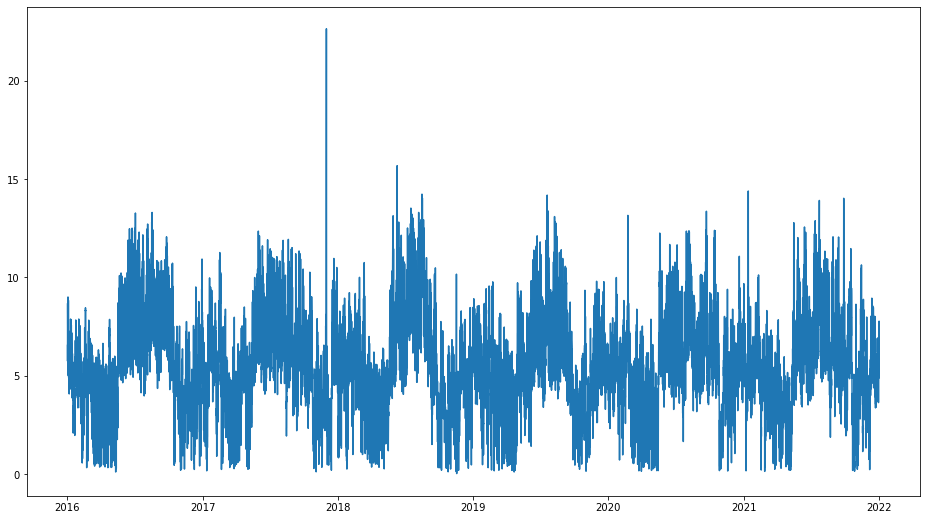

In [ ]:
wind_data = (data[[target_var]]).iloc[:,-1].values

# wind_data
plt.figure(figsize=(16,9))
plt.plot(data.index,wind_data)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b042f375-baca-4c84-a14b-37523ae4dfb4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>